In [1]:
import pandas as pd
import numpy as np
import opendap_python_example.simple_file_downloader as sfd
import urllib3
from os import listdir
from time import time
import datetime

from multiprocessing.pool import ThreadPool

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as mtick

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


formats = [
    "%y",  # ticks are mostly years
    "%b",  # ticks are mostly months
    "%d",  # ticks are mostly days
    "%H:%M",  # hrs
    "%H:%M",  # min
    "%S.%f",
]  # secs
# these are mostly just the level above...
zero_formats = [""] + formats[:-1]
# ...except for ticks that are mostly hours, then it is nice to have
# month-day:
zero_formats[3] = "%d-%b"
# and months it's nice to have full year
zero_formats[1] = "%Y"

offset_formats = [
    "",
    "%Y",
    "%b %Y",
    "%d %b %Y",
    "%d %b %Y",
    "%d %b %Y %H:%M",
]

converter = mdates.ConciseDateConverter(
    formats=formats, zero_formats=zero_formats, offset_formats=offset_formats
)

munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

## Temperatures

### Data Cleaning and Transformation

Write to csv for easier reading in the future

In [13]:
temps_df = pd.read_csv("temps_weather_data.csv")

temps_df.ob_end_time = temps_df.ob_end_time.astype("datetime64")
temps_df.meto_stmp_time = temps_df.meto_stmp_time.astype("datetime64")

/Users/angus/opt/anaconda3/envs/weather/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (4,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Generate sample for faster transformations

In [ ]:
# sample_temps = pd.read_csv('temps_sample.csv')

### Create national temperature averages for daily analysis

In [15]:
# national_temps = (
#     temps_df.set_index("ob_end_time")
#     .resample("1d")
#     .agg({"max_air_temp": "mean", "min_air_temp": "mean",})
# )

In [ ]:
# national_temps.to_csv("national_temps.csv")

national_temps = pd.read_csv("national_temps.csv")

In [16]:
national_temps.head()

,max_air_temp,min_air_temp
ob_end_time,,
1853-01-01,NaN,7.6
1853-01-02,11.1,7.2
1853-01-03,11.3,3.6
1853-01-04,9.9,5.6
1853-01-05,11.7,1.4


In [17]:
# rolling 90 day mean for seasonal analysis

national_temps["rolling_90_mean_max"] = (
    national_temps.sort_index().max_air_temp.rolling("90d").mean()
)
national_temps["rolling_90_mean_min"] = (
    national_temps.sort_index().min_air_temp.rolling("90d").mean()
)

In [18]:
national_temps.head()

,max_air_temp,min_air_temp,rolling_90_mean_max,rolling_90_mean_min
ob_end_time,,,,
1853-01-01,NaN,7.6,NaN,7.600000
1853-01-02,11.1,7.2,11.100000,7.400000
1853-01-03,11.3,3.6,11.200000,6.133333
1853-01-04,9.9,5.6,10.766667,6.000000
1853-01-05,11.7,1.4,11.000000,5.080000


In [19]:
# create month and day columns, and set arbitrary year (2000) so the data is 'year-normalised'


def normalise_dates(df):

    # normally window function adds the label to the end of the period
    # for ease of understanding, bringing label forward 90 days
    # so the label is the beginning of the coldest 90 day period
    # ie the beginning of 'winter'
    df["new_date"] = df.Date - datetime.timedelta(days=90)

    df["month"] = df.new_date.dt.month
    df["day"] = df.new_date.dt.day
    df["year"] = 2000

    df["new_date"] = pd.to_datetime(df[["year", "month", "day"]], yearfirst=True)

    return df

In [20]:
# find coldest rolling window
# coldest_max_temps = pd.DataFrame(columns=["Date", "Temperature"])


def year_temps_summary_function(df, metric):
    min_df = pd.DataFrame(columns=["Date", "Temperature"])
    max_df = pd.DataFrame(columns=["Date", "Temperature"])

    if metric == "min":
        for year in df.index.year.unique():
            min_val = df.loc[df.index.year == year, "rolling_90_mean_min"].min()
            min_date = df.loc[
                (df.rolling_90_mean_min == min_val) & (df.index.year == year)
            ].index

            max_val = df.loc[df.index.year == year, "rolling_90_mean_max"].min()
            max_date = df.loc[
                (df.rolling_90_mean_max == max_val) & (df.index.year == year)
            ].index

            try:
                min_df = min_df.append(
                    {"Date": min_date.values[0], "Temperature": min_val},
                    ignore_index=True,
                )
                max_df = max_df.append(
                    {"Date": max_date.values[0], "Temperature": max_val},
                    ignore_index=True,
                )
            except IndexError:
                continue

    elif metric == "max":
        for year in df.index.year.unique():
            min_val = df.loc[df.index.year == year, "rolling_90_mean_min"].max()
            min_date = df.loc[
                (df.rolling_90_mean_min == min_val) & (df.index.year == year)
            ].index

            max_val = df.loc[df.index.year == year, "rolling_90_mean_max"].max()
            max_date = df.loc[
                (df.rolling_90_mean_max == max_val) & (df.index.year == year)
            ].index

            try:
                min_df = min_df.append(
                    {"Date": min_date.values[0], "Temperature": min_val},
                    ignore_index=True,
                )
                max_df = max_df.append(
                    {"Date": max_date.values[0], "Temperature": max_val},
                    ignore_index=True,
                )
            except IndexError:
                continue

    else:
        raise ValueError("Metric must be 'min' or 'max'")

    return normalise_dates(min_df), normalise_dates(max_df)

In [21]:
cold_min, cold_max = year_temps_summary_function(national_temps, "min")
hot_min, hot_max = year_temps_summary_function(national_temps, "max")

## Rain

In [ ]:
rain_df = pd.read_csv("rain_weather_data.csv")

Generate sample for faster transformations

In [ ]:
# sample_rain = pd.read_csv('rain_sample.csv')

### Data Cleaning and Transformation

In [23]:
good_columns = [
    "ob_date",
    "id",
    "id_type",
    "version_num",
    "met_domain_name",
    "ob_end_ctime",
    "ob_day_cnt",
    "src_id",
    "rec_st_ind",
    "prcp_amt",
    "ob_day_cnt_q",
    "prcp_amt_q",
    "prcp_amt_j",
    "meto_stmp_time",
    "midas_stmp_etime",
]

In [24]:
rain_drop = [column for column in rain_df.columns if column not in good_columns]

In [25]:
rain_df.drop(columns=rain_drop, inplace=True)

In [26]:
rain_df.head()

,ob_date,id,id_type,version_num,met_domain_name,ob_end_ctime,ob_day_cnt,src_id,rec_st_ind,prcp_amt,ob_day_cnt_q,prcp_amt_q,prcp_amt_j,meto_stmp_time,midas_stmp_etime
0,1966-01-02 00:00:00,773322.0,RAIN,1.0,DLY3208,900.0,1.0,49.0,1001.0,0.0,0.0,9.0,NaN,NaN,NaN
1,1966-01-03 00:00:00,773322.0,RAIN,1.0,DLY3208,900.0,1.0,49.0,1001.0,2.5,0.0,9.0,NaN,NaN,NaN
2,1966-01-04 00:00:00,773322.0,RAIN,1.0,DLY3208,900.0,1.0,49.0,1001.0,0.0,0.0,9.0,NaN,NaN,NaN
3,1966-01-05 00:00:00,773322.0,RAIN,1.0,DLY3208,900.0,1.0,49.0,1001.0,2.3,0.0,9.0,NaN,NaN,NaN
4,1966-01-06 00:00:00,773322.0,RAIN,1.0,DLY3208,900.0,1.0,49.0,1001.0,0.5,0.0,9.0,NaN,NaN,NaN


In [27]:
rain_df.ob_date = rain_df.ob_date.astype("datetime64")

### Create national rain averages for daily analysis

In [31]:
national_rain = (
    rain_df.set_index("ob_date").resample("1d").agg({"prcp_amt": ["mean", "sum"]})
)

In [ ]:
# national_rain.prcp_amt

In [28]:
# national_rain.to_csv("national_rain.csv")

national_rain = pd.read_csv("national_rain.csv")

In [32]:
national_rain

prcp_amt       
                mean    sum
ob_date                    
1853-01-02  0.650000    1.3
1853-01-03  0.250000    0.5
1853-01-04  4.250000    8.5
1853-01-05  1.600000    3.2
1853-01-06  4.250000    8.5
...              ...    ...
2019-12-27  5.279200  659.9
2019-12-28  1.559016  190.2
2019-12-29  0.724576   85.5
2019-12-30  0.590517   68.5
2019-12-31  0.390756   46.5

[60994 rows x 2 columns]

In [33]:
# rolling 90 day sum for seasonal analysis

national_rain["rolling_average_90_sum"] = (
    national_rain.sort_index().prcp_amt["mean"].rolling("90d").sum()
)
national_rain[national_rain.rolling_average_90_sum < 0] = 0

national_rain["rolling_total_90_sum"] = (
    national_rain.sort_index().prcp_amt["sum"].rolling("90d").sum()
)
national_rain[national_rain.rolling_total_90_sum < 0] = 0

In [34]:
# find coldest rolling window
# coldest_max_temps = pd.DataFrame(columns=["Date", "Temperature"])


def year_rain_summary_function(df, scope):
    max_df = pd.DataFrame(columns=["Date", "Rain"])
    min_df = pd.DataFrame(columns=["Date", "Rain"])

    if scope == "average":
        for year in df.index.year.unique():

            max_val = df.loc[df.index.year == year, "rolling_average_90_sum"].max()
            max_date = df.loc[
                (df.rolling_average_90_sum == max_val) & (df.index.year == year)
            ].index

            min_val = df.loc[df.index.year == year, "rolling_average_90_sum"].min()
            min_date = df.loc[
                (df.rolling_average_90_sum == min_val) & (df.index.year == year)
            ].index

            #             try:
            max_df = max_df.append(
                {"Date": max_date.values[0], "Rain": max_val}, ignore_index=True,
            )

            min_df = min_df.append(
                {"Date": min_date.values[0], "Rain": min_val}, ignore_index=True,
            )
    #             except IndexError:
    #                 continue

    elif scope == "total":
        for year in df.index.year.unique():

            max_val = df.loc[df.index.year == year, "rolling_total_90_sum"].max()
            max_date = df.loc[
                (df.rolling_total_90_sum == max_val) & (df.index.year == year)
            ].index

            min_val = df.loc[df.index.year == year, "rolling_total_90_sum"].min()
            min_date = df.loc[
                (df.rolling_total_90_sum == min_val) & (df.index.year == year)
            ].index

            try:
                max_df = max_df.append(
                    {"Date": max_date.values[0], "Rain": max_val}, ignore_index=True,
                )

                min_df = min_df.append(
                    {"Date": min_date.values[0], "Rain": min_val}, ignore_index=True,
                )
            except IndexError:
                pass
    else:
        raise ValueError("Scope must be either total or average")

    return normalise_dates(min_df), normalise_dates(max_df)

In [35]:
rain_avg_min, rain_avg_max = year_rain_summary_function(national_rain, "average")
rain_total_min, rain_total_max = year_rain_summary_function(national_rain, "total")

## Wind

In [ ]:
# wind_df = pd.read_csv("wind_weather_data.csv")

In [ ]:
sample_wind = pd.read_csv('wind_sample.csv')

Generate sample for faster transformations

In [76]:
wind_sample.head()

,ob_end_time,id_type,id,ob_hour_count,met_domain_name,version_num,src_id,rec_st_ind,mean_wind_dir,mean_wind_speed,...,midas_stmp_etime,00074,DINGWALL,dingwall,ross-and-cromarty,57.600,-4.447,7,1998,1999
0,2009-01-09 11:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,845.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-09 12:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,786.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-09 13:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,673.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-09 14:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-09 15:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning and Transformation

In [78]:
good_columns = [
    "ob_end_time",
    "id_type",
    "id",
    "ob_hour_count",
    "met_domain_name",
    "version_num",
    "src_id",
    "rec_st_ind",
    "mean_wind_dir",
    "mean_wind_speed",
    "max_gust_dir",
    "max_gust_speed",
    "max_gust_ctime",
    "mean_wind_dir_q",
    "mean_wind_speed_q",
    "max_gust_dir_q",
    "max_gust_speed_q",
    "max_gust_ctime_q",
    "mean_wind_dir_j",
    "mean_wind_speed_j",
    "max_gust_dir_j",
    "max_gust_speed_j",
]

In [101]:
wind_drop = [column for column in wind_df.columns if column not in good_columns]

In [102]:
wind_df.drop(columns=wind_drop, inplace=True)

In [103]:
wind_df.head()

,ob_end_time,id_type,id,ob_hour_count,met_domain_name,version_num,src_id,rec_st_ind,mean_wind_dir,mean_wind_speed,...,max_gust_ctime,mean_wind_dir_q,mean_wind_speed_q,max_gust_dir_q,max_gust_speed_q,max_gust_ctime_q,mean_wind_dir_j,mean_wind_speed_j,max_gust_dir_j,max_gust_speed_j
0,2009-01-09 11:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,951.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,2009-01-09 12:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,1051.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,2009-01-09 13:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,1151.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,2009-01-09 14:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,1251.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,2009-01-09 15:00:00,WIND,367201.0,1.0,HCM,0.0,498.0,1011.0,0.0,0.0,...,1351.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [104]:
wind_df.ob_end_time = wind_df.ob_end_time.astype("datetime64")

### Create national wind averages for daily analysis

In [105]:
national_wind = (
    wind_df.set_index("ob_end_time")
    .resample("1d")
    .agg({"mean_wind_speed": "mean", "max_gust_speed": "mean"})
)

In [107]:
# national_wind.to_csv("national_wind.csv")

# national_wind = pd.read_csv("national_wind.csv")

In [108]:
# rolling 90 day sum for seasonal analysis

national_wind["rolling_average_90_mean"] = (
    national_wind.sort_index().mean_wind_speed.rolling("90d").mean()
)
# national_wind[national_wind["rolling_average_90_sum"] < 0] = 0

national_wind["rolling_max_gust_90_mean"] = (
    national_wind.sort_index().max_gust_speed.rolling("90d").mean()
)
# national_wind[national_wind.rolling_total_90_sum < 0] = 0

In [169]:
# find coldest rolling window
# coldest_max_temps = pd.DataFrame(columns=["Date", "Temperature"])


def year_wind_summary_function(df, scope):
    max_df = pd.DataFrame(columns=["Date", "Wind"])
    min_df = pd.DataFrame(columns=["Date", "Wind"])

    if scope == "normal":
        for year in df.index.year.unique():

            max_val = df.loc[df.index.year == year, "rolling_average_90_mean"].max()
            #             print(max_val)
            #             print(max_val is not np.nan)
            max_date = df.loc[
                (df.rolling_average_90_mean == max_val) & (df.index.year == year)
            ].index
            #             print(max_date)
            min_val = df.loc[df.index.year == year, "rolling_average_90_mean"].min()
            min_date = df.loc[
                (df.rolling_average_90_mean == min_val) & (df.index.year == year)
            ].index

            #         print(max_val, "check nan:")

            if max_val is not np.nan:
                #                 print(max_val)
                max_df = max_df.append(
                    {"Date": max_date.values[0], "Wind": max_val}, ignore_index=True,
                )

            if min_val is not np.nan:
                min_df = min_df.append(
                    {"Date": min_date.values[0], "Wind": min_val}, ignore_index=True,
                )

    elif scope == "gust":
        for year in df.index.year.unique():

            max_val = df.loc[df.index.year == year, "rolling_max_gust_90_mean"].max()
            max_date = df.loc[
                (df.rolling_max_gust_90_mean == max_val) & (df.index.year == year)
            ].index

            min_val = df.loc[df.index.year == year, "rolling_max_gust_90_mean"].min()
            min_date = df.loc[
                (df.rolling_max_gust_90_mean == min_val) & (df.index.year == year)
            ].index

            try:
                max_df = max_df.append(
                    {"Date": max_date.values[0], "Wind": max_val}, ignore_index=True,
                )

                min_df = min_df.append(
                    {"Date": min_date.values[0], "Wind": min_val}, ignore_index=True,
                )
            except IndexError:
                pass
    else:
        raise ValueError("Scope must be either normal or gust")

    return normalise_dates(min_df), normalise_dates(max_df)

In [170]:
wind_min, wind_max = year_wind_summary_function(national_wind, "normal")
wind_gust_min, wind_gust_max = year_wind_summary_function(national_wind, "gust")

# Analysis

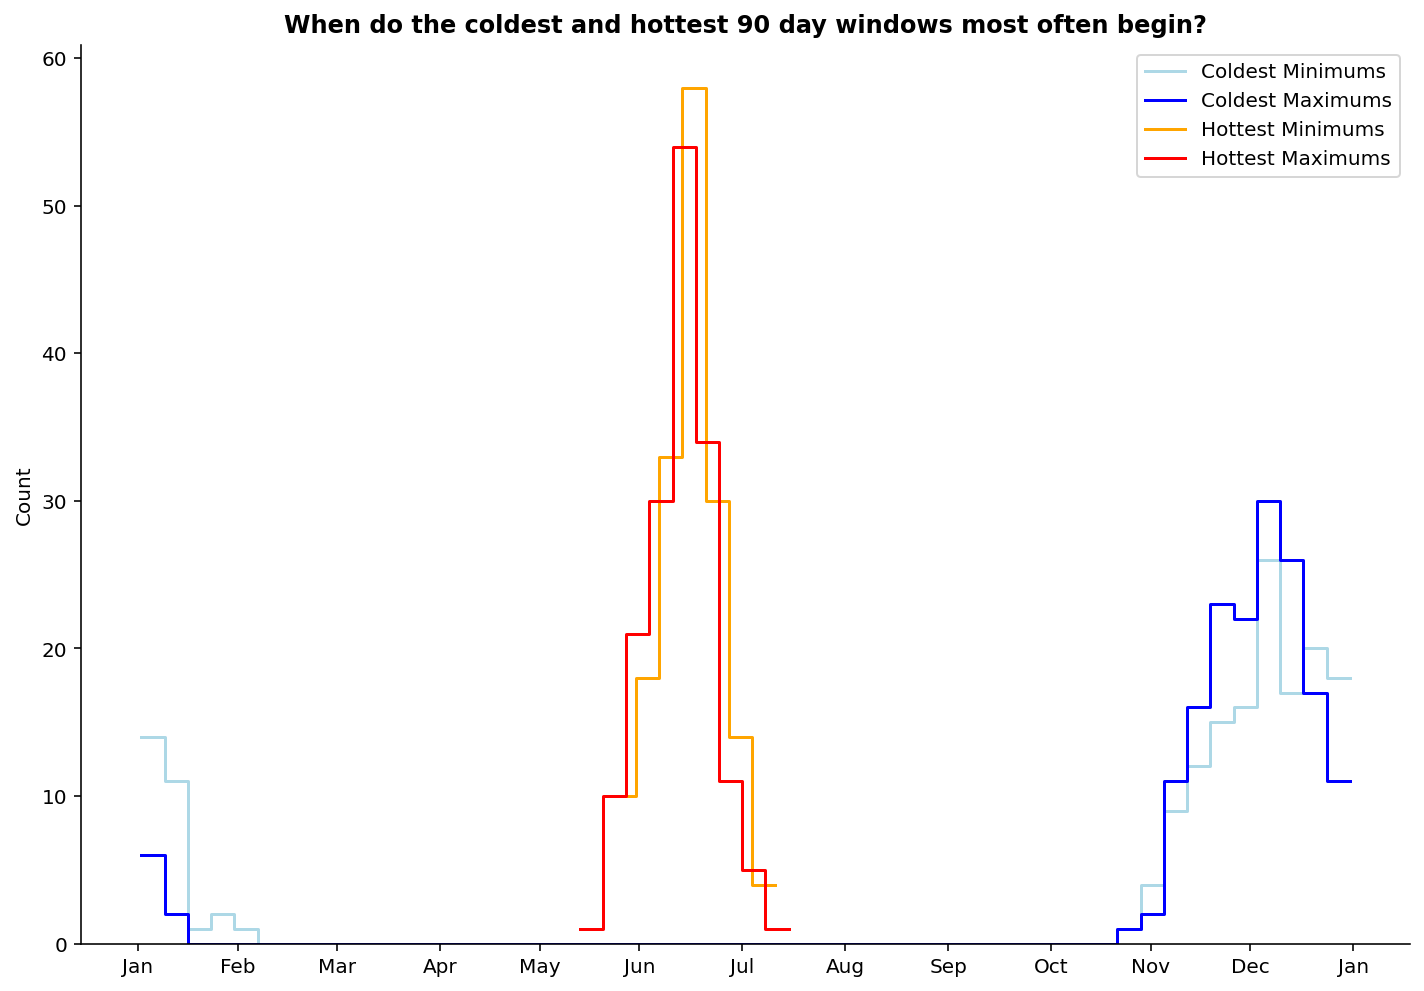

In [52]:
bin_width = 7

plt.figure(figsize=(10, 7))
ax = plt.subplot()

sns.histplot(
    x=cold_min.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Coldest Minimums",
    color="lightblue",
)
sns.histplot(
    x=cold_max.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Coldest Maximums",
    color="blue",
)
sns.histplot(
    x=hot_min.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Hottest Minimums",
    color="orange",
)
sns.histplot(
    x=hot_max.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Hottest Maximums",
    color="red",
)

# improve x ticks
current_ticks = ax.get_xticks()

new_ticks = [0 for i in range(2 * len(current_ticks) - 1)]
new_ticks[::2] = [tick for tick in current_ticks]
new_ticks[1::2] = [
    ((new_ticks[i - 1] + new_ticks[i + 1]) / 2).round() for i in [1, 3, 5, 7, 9, 11]
]

ax.set_xticks(new_ticks)
ax.set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
        "Jan",
    ]
)
plt.xlabel(None)
plt.title(
    "When do the coldest and hottest 90 day windows most often begin?",
    fontweight="bold",
)
plt.legend()
sns.despine()
plt.tight_layout()

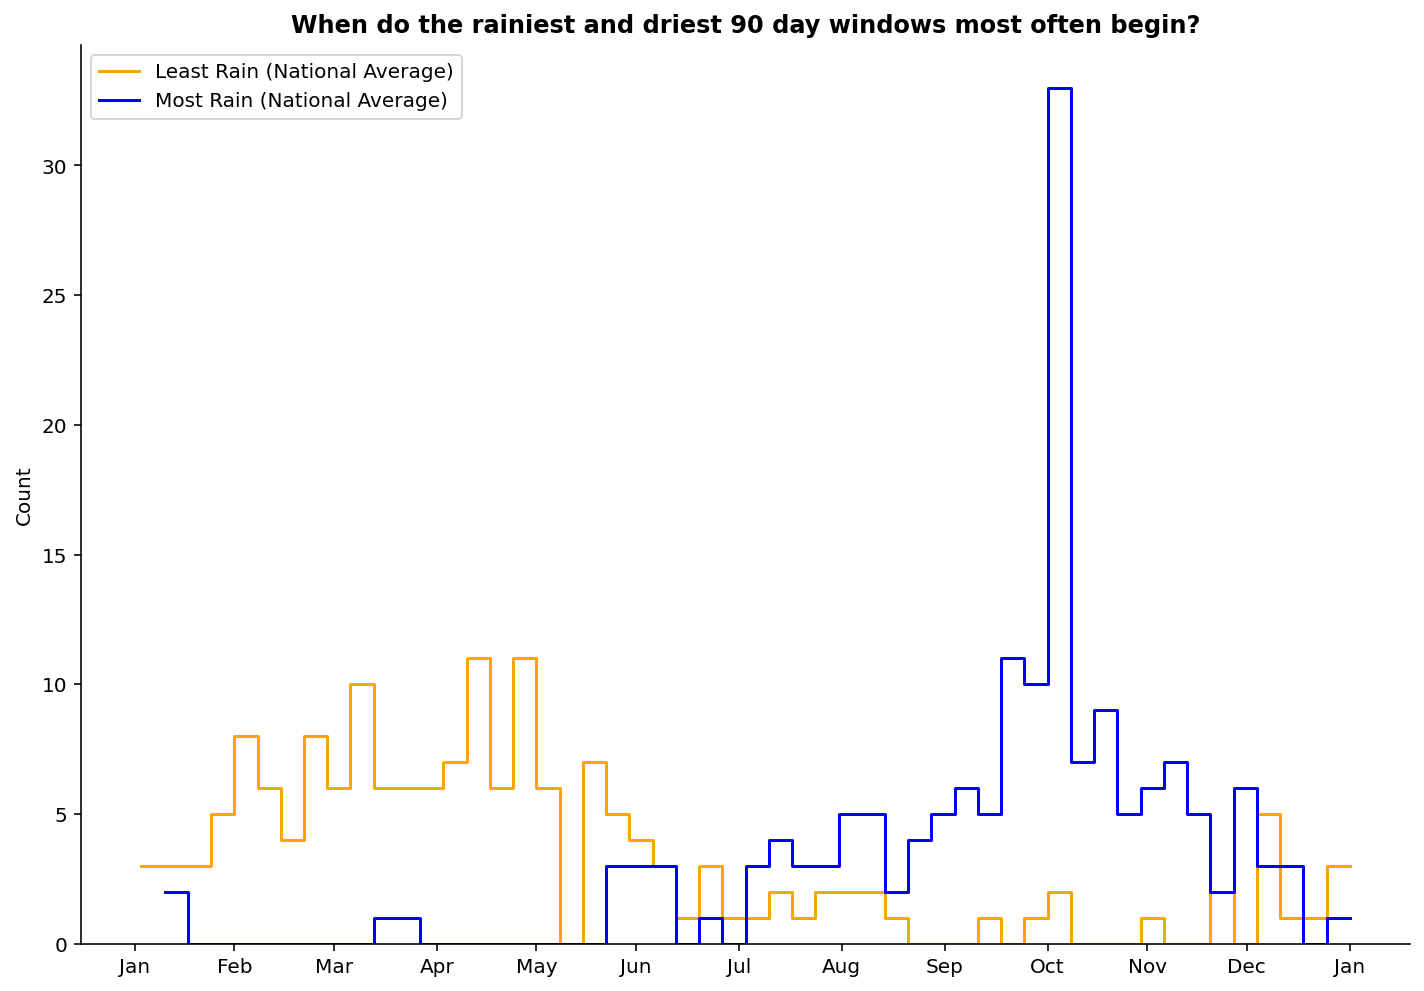

In [177]:
bin_width = 7

plt.figure(figsize=(10, 7))
ax = plt.subplot()

sns.histplot(
    x=rain_avg_min.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Least Rain (National Average)",
    color="orange",
)
sns.histplot(
    x=rain_avg_max.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Most Rain (National Average)",
    color="blue",
)
# sns.histplot(
#     x=rain_total_min.new_date,
#     element="step",
#     binwidth=bin_width,
#     fill=False,
#     label="Least Rain (National Total)",
#     color="red",
# )
# sns.histplot(
#     x=rain_total_max.new_date,
#     element="step",
#     binwidth=bin_width,
#     fill=False,
#     label="Most Rain (National Total)",
#     color="blue",
# )

# improve x ticks
current_ticks = ax.get_xticks()

new_ticks = [0 for i in range(2 * len(current_ticks) - 1)]
new_ticks[::2] = [tick for tick in current_ticks]
new_ticks[1::2] = [
    ((new_ticks[i - 1] + new_ticks[i + 1]) / 2).round() for i in [1, 3, 5, 7, 9, 11]
]

ax.set_xticks(new_ticks)
ax.set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
        "Jan",
    ]
)
plt.xlabel(None)
plt.title(
    "When do the rainiest and driest 90 day windows most often begin?",
    fontweight="bold",
)
plt.legend()
sns.despine()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.histplot(
    x=coldest_max_temps.new_date,
    element="step",
    bins=104,
    fill=False,
    label="Coldest Maximum Temps",
)
sns.histplot(
    x=coldest_min_temps.new_date,
    element="step",
    bins=104,
    fill=False,
    label="Coldest Minimum Temps",
)
plt.xlim((11232.0, 11350.0))

In [118]:
wind_gust_min

,Date,Wind,new_date,month,day,year
0,1949-09-04,19.312963,2000-06-06,6,6,2000
1,1950-08-07,22.575000,2000-05-09,5,9,2000
2,1951-11-01,21.896296,2000-08-03,8,3,2000
3,1952-07-09,22.914815,2000-04-10,4,10,2000
4,1953-03-25,20.825926,2000-12-25,12,25,2000
...,...,...,...,...,...,...
66,2015-11-04,13.385942,2000-08-06,8,6,2000
67,2016-08-02,13.688102,2000-05-04,5,4,2000
68,2017-09-10,14.677822,2000-06-12,6,12,2000
69,2018-08-09,12.566922,2000-05-11,5,11,2000


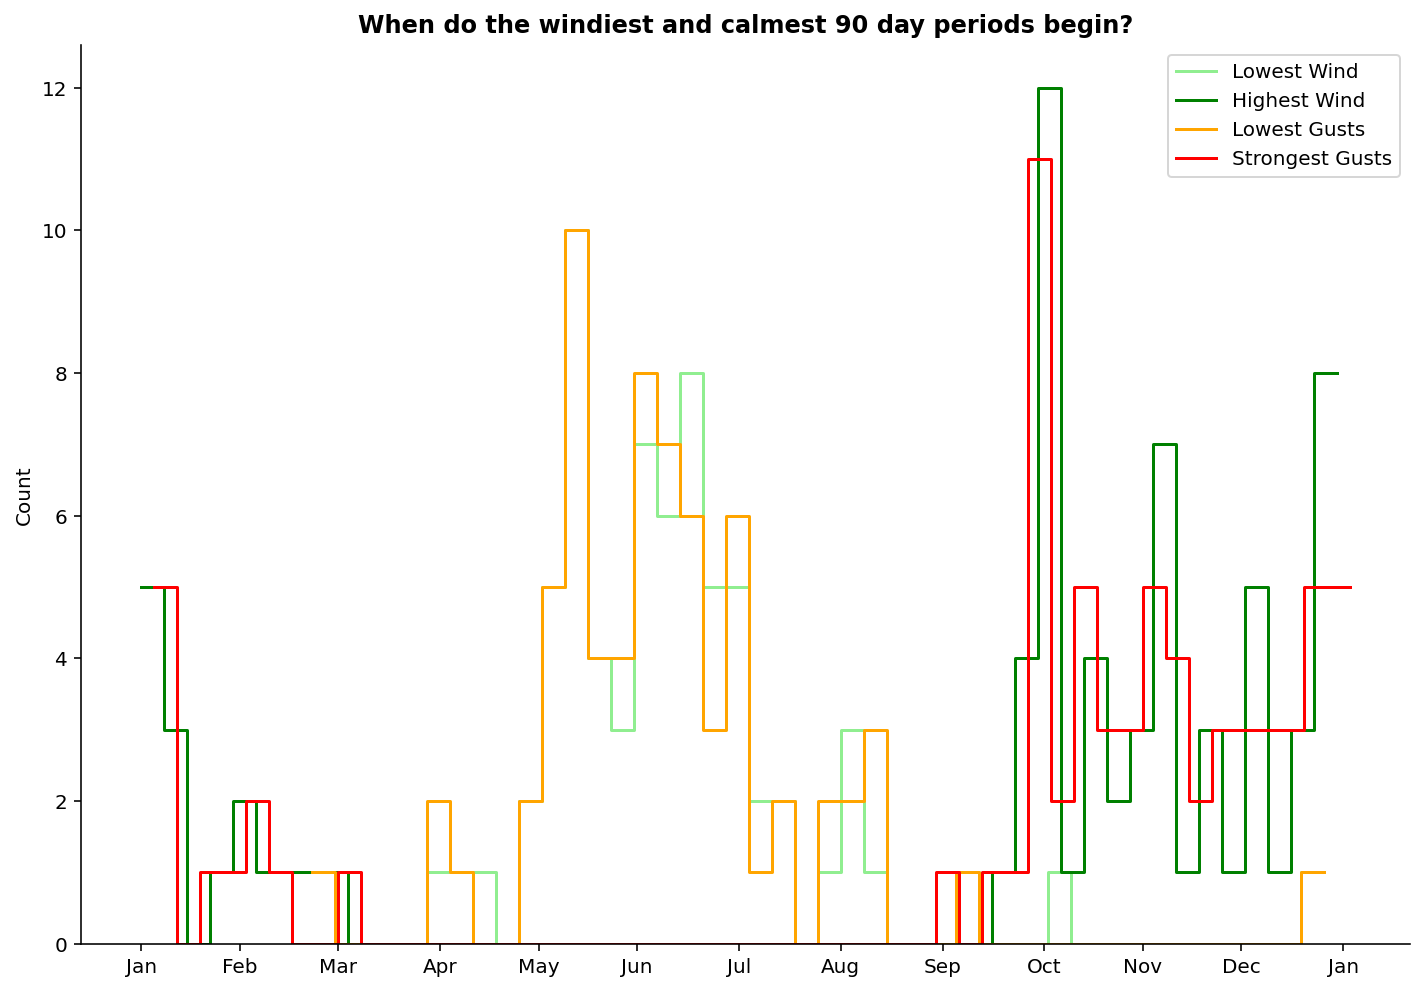

In [185]:
bin_width = 7

plt.figure(figsize=(10, 7))
ax = plt.subplot()

sns.histplot(
    x=wind_min.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Lowest Wind",
    color="lightgreen",
)
sns.histplot(
    x=wind_max.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Highest Wind",
    color="green",
)
sns.histplot(
    x=wind_gust_min.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Lowest Gusts",
    color="orange",
)
sns.histplot(
    x=wind_gust_max.new_date,
    element="step",
    binwidth=bin_width,
    fill=False,
    label="Strongest Gusts",
    color="red",
)

# improve x ticks
current_ticks = ax.get_xticks()

new_ticks = [0 for i in range(2 * len(current_ticks) - 1)]
new_ticks[::2] = [tick for tick in current_ticks]
new_ticks[1::2] = [
    ((new_ticks[i - 1] + new_ticks[i + 1]) / 2).round() for i in [1, 3, 5, 7, 9, 11]
]

ax.set_xticks(new_ticks)
ax.set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
        "Jan",
    ]
)
plt.xlabel(None)
plt.title(
    "When do the windiest and calmest 90 day periods begin?", fontweight="bold",
)
plt.legend()
sns.despine()
plt.tight_layout()

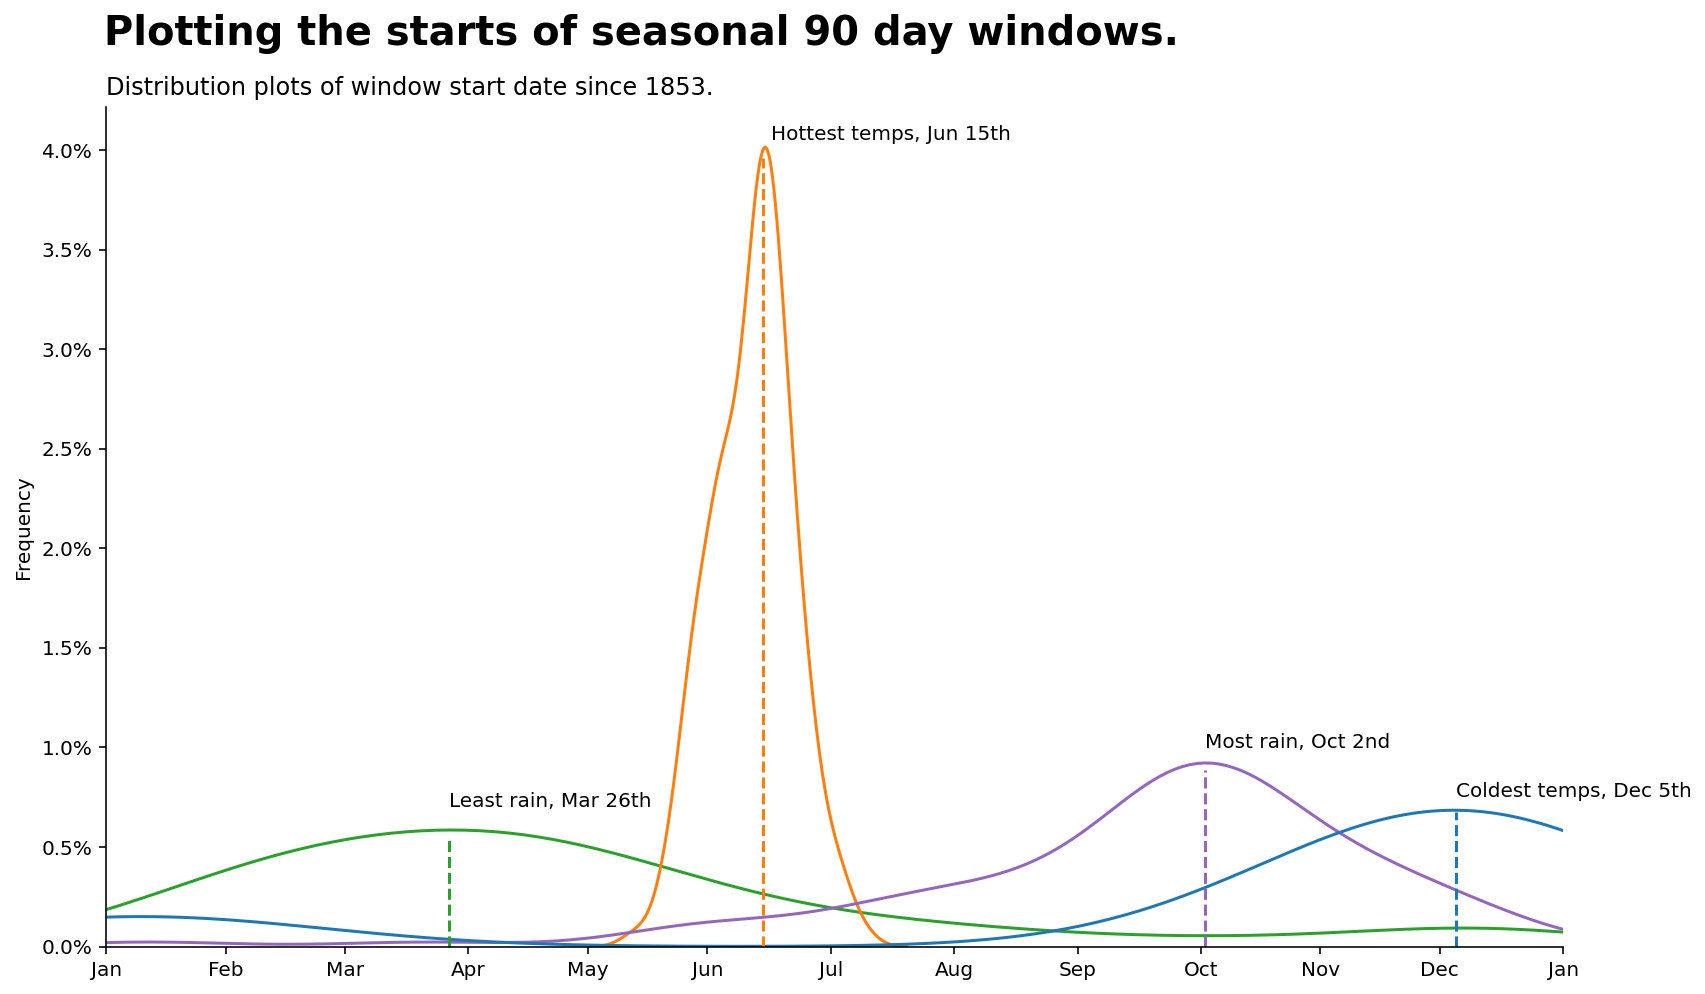

In [327]:
plt.figure(figsize=(12, 7))
ax = plt.subplot()

#spring
sns.kdeplot(
    rain_avg_min.new_date,
#     label="Least Rain",
    color="#2ca02c",
    clip=(10957, 11323),
)

#summer
sns.kdeplot(
    hot_max.new_date,
#     label="June 15th\nHottest Temperatures",
    color="#ff7f0e",
    clip=(10957, 11323),
)

#Autumn
sns.kdeplot(
    rain_avg_max.new_date,
#     label="Most Rain",
    color="#9467bd",
    clip=(10957, 11323),
)

# Winter
sns.kdeplot(
    cold_min.new_date,
#     label="Coldest Temperatures",
    color="#1f77b4",
    clip=(10957, 11323),
)


# improve ticks
# x
current_ticks = ax.get_xticks()

new_ticks = [0 for i in range(2 * len(current_ticks) - 1)]
new_ticks[::2] = [tick for tick in current_ticks]
new_ticks[1::2] = [
    ((new_ticks[i - 1] + new_ticks[i + 1]) / 2).round() for i in [1, 3, 5, 7, 9, 11]
]

ax.set_xticks(new_ticks)
ax.set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
        "Jan",
    ]
)

# y ticks
fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.PercentFormatter(xmax=1, decimals=1)
ax.yaxis.set_major_formatter(yticks)

plt.axvline(x=11043, ymax=0.13, color="#2ca02c", linestyle="--")
plt.annotate(text="Least rain, Mar 26th", xy=(11043, 0.007))

plt.axvline(x=11122, ymax=0.94, color="#ff7f0e", linestyle="--")
plt.annotate(text="Hottest temps, Jun 15th", xy=(11124, 0.0405), ha="left")

plt.axvline(x=11233, ymax=0.21, color="#9467bd", linestyle="--")
plt.annotate(text="Most rain, Oct 2nd", xy=(11233, 0.01))

plt.axvline(x=11296, ymax=0.16, color="#1f77b4", linestyle="--")
plt.annotate(text="Coldest temps, Dec 5th", xy=(11296, 0.0075))


plt.xlim((current_ticks[0], current_ticks[-1]))
plt.xlabel(None)
plt.ylabel("Frequency")

plt.suptitle("Plotting the starts of seasonal 90 day windows.", ha='left', fontweight='bold', x=0.065, fontsize=20)
plt.title("Distribution plots of window start date since 1853.", x=0, ha='left')

# plt.legend(frameon=False, loc='upper left')
sns.despine()
plt.tight_layout()
# plt.savefig('./reports/90_day_window_plot.pdf', dpi=300)